In [25]:
# python v3.11.8
# import necessary packages

import os
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import seaborn as sns

sys.path.append('functions')

from greatbrowser import great_analysis

from gene_analysis_functions import get_cistrome, get_pos, insig_nan
from pseudoinverse_functions import pinv_dropmin, quality_filter, trait_cluster, count_cumulative_probes

# set threshholds
trait_thresh = 0.60
probe_thresh = 0.50
similarity_filter = 0.70

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Establish the CWD, import relevant data, and perform basic formatting

In [3]:
# set directory, import data, drop undefined
os.chdir('C:\\Users\\Q004\\Desktop\\pellegrini_lab_research\\raw_data')
#os.chdir('C:\\Users\\Sam Anderson\\Desktop\\pellegrini_lab_research\\raw_data')

data = pd.read_excel('methylation_phenotype_encoded.xlsx', index_col=0) # mm39
data = data.dropna()

# referring to the point in the data where methylation and phenotype data diverge
sep=55

# seperate trait and methylation data
trait_data = data[:sep]
meth_data = data[sep:]

print(f'{trait_data.shape[0]} traits')

55 traits


Scale (not normalize) each row by dividing it by its standard deviation

In [4]:
# avoid scaling the categorical variables
no_categorical = trait_data.drop(['CD1 or C57BL6J?', 'C57BL6J or Sv129Ev?', 'Rank', 'High Fat Diet?'])
no_categorical = no_categorical.T

# divide each row (trait) by its standard deviation
trait_data_std = (no_categorical-no_categorical.mean())/no_categorical.std()

# add the categorical variables back to the dataframe
categorical_vars = trait_data.loc[['CD1 or C57BL6J?', 'C57BL6J or Sv129Ev?', 'Rank', 'High Fat Diet?']]

trait_data_std = trait_data_std.T
trait_data_std = pd.concat([trait_data_std, categorical_vars], axis=0)

Filter the trait data to remove collinearity

In [15]:
f_trait_data, masked_corr = quality_filter(trait_data_std, similarity_filter)

print(f'{f_trait_data.shape[0]} traits')

19 traits


Show collinearity as a heatmap

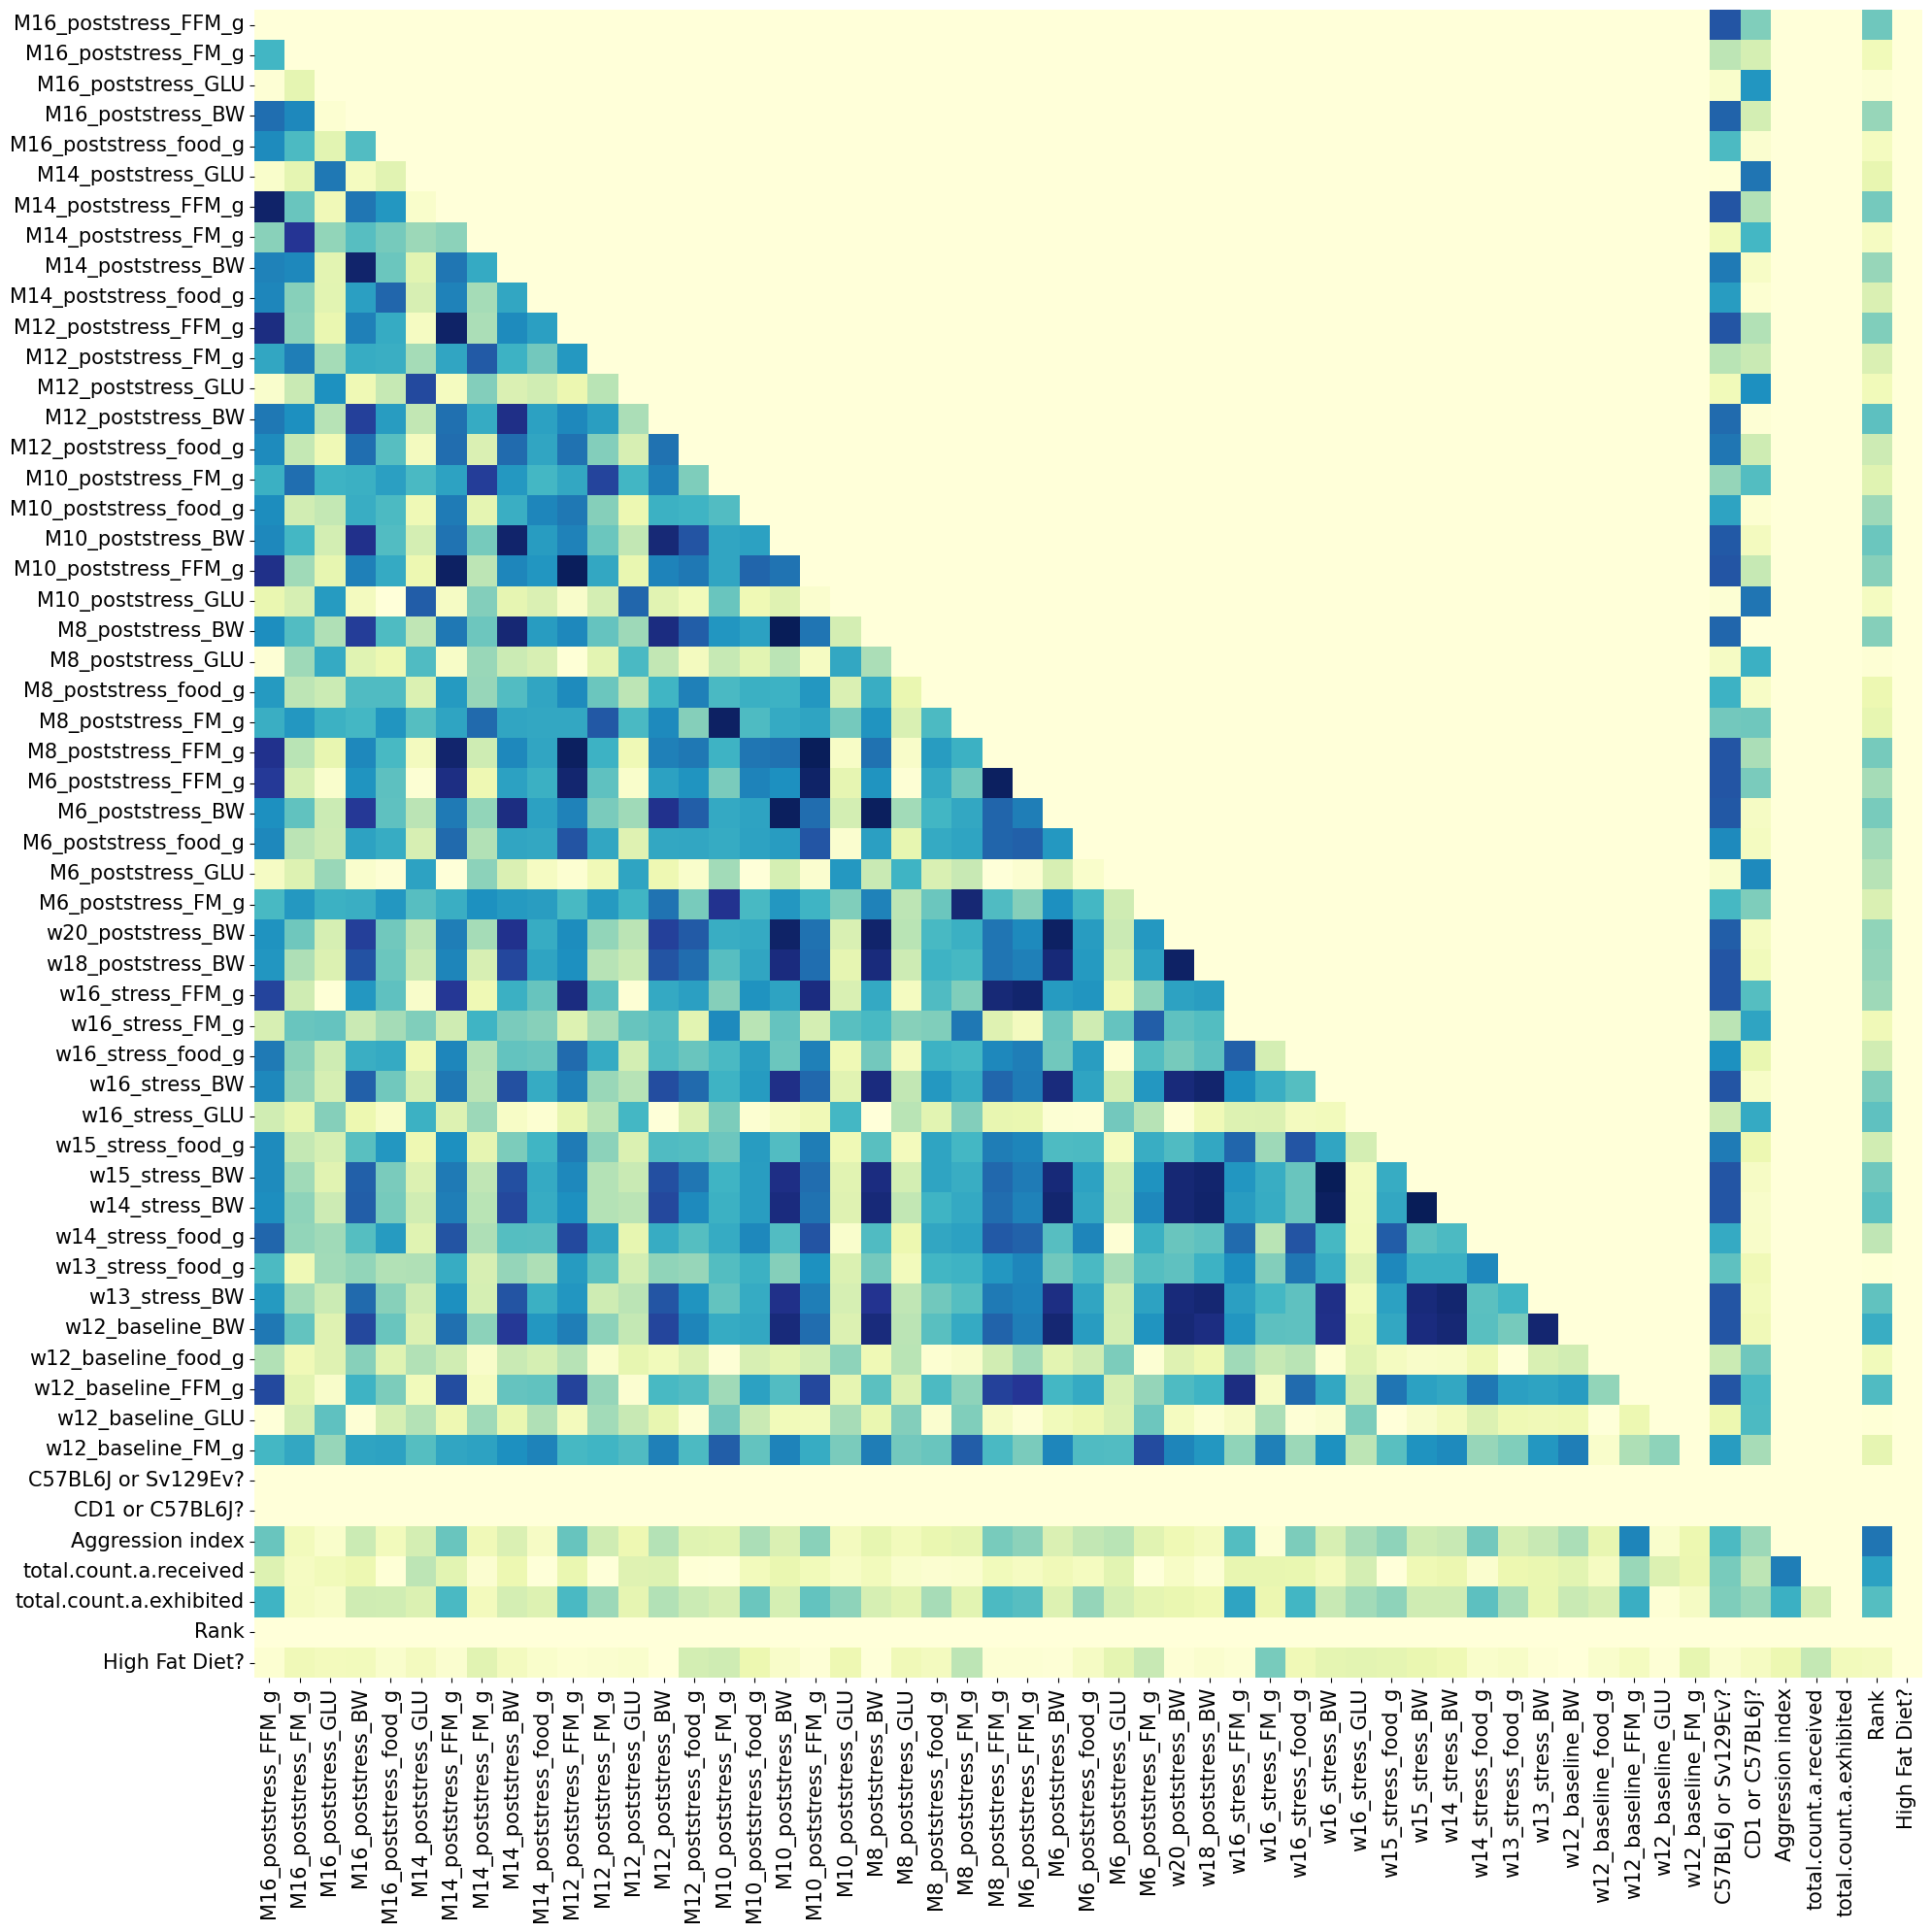

In [71]:
plt.figure(figsize=(20, 20))
sns.heatmap(masked_corr, annot=False, cmap='YlGnBu', cbar=False, square=True)

plt.xlabel('')
plt.ylabel('')
plt.xticks(size=15)
plt.yticks(size=15)

plt.tight_layout()

In [73]:
# get the corr values for the trait/trait pairs, and p values for the site/trait pairs
pred, actual, trait_vals, trait_pvals = pinv_dropmin(f_trait_data, meth_data, trait_thresh, 
             find_meth=False, probe_thresh=probe_thresh);

Create a plot with 

1. a heatmap showing prediction accuracy across all traits

2. An empty space for equations

3. a heatmap of the probe/trait MMR AdjP values

4. a heatmap of the probe/trait MMR AdjP values "zoomed" in on a specific trait

Create a heatmap showing the prediction accuracy across all traits

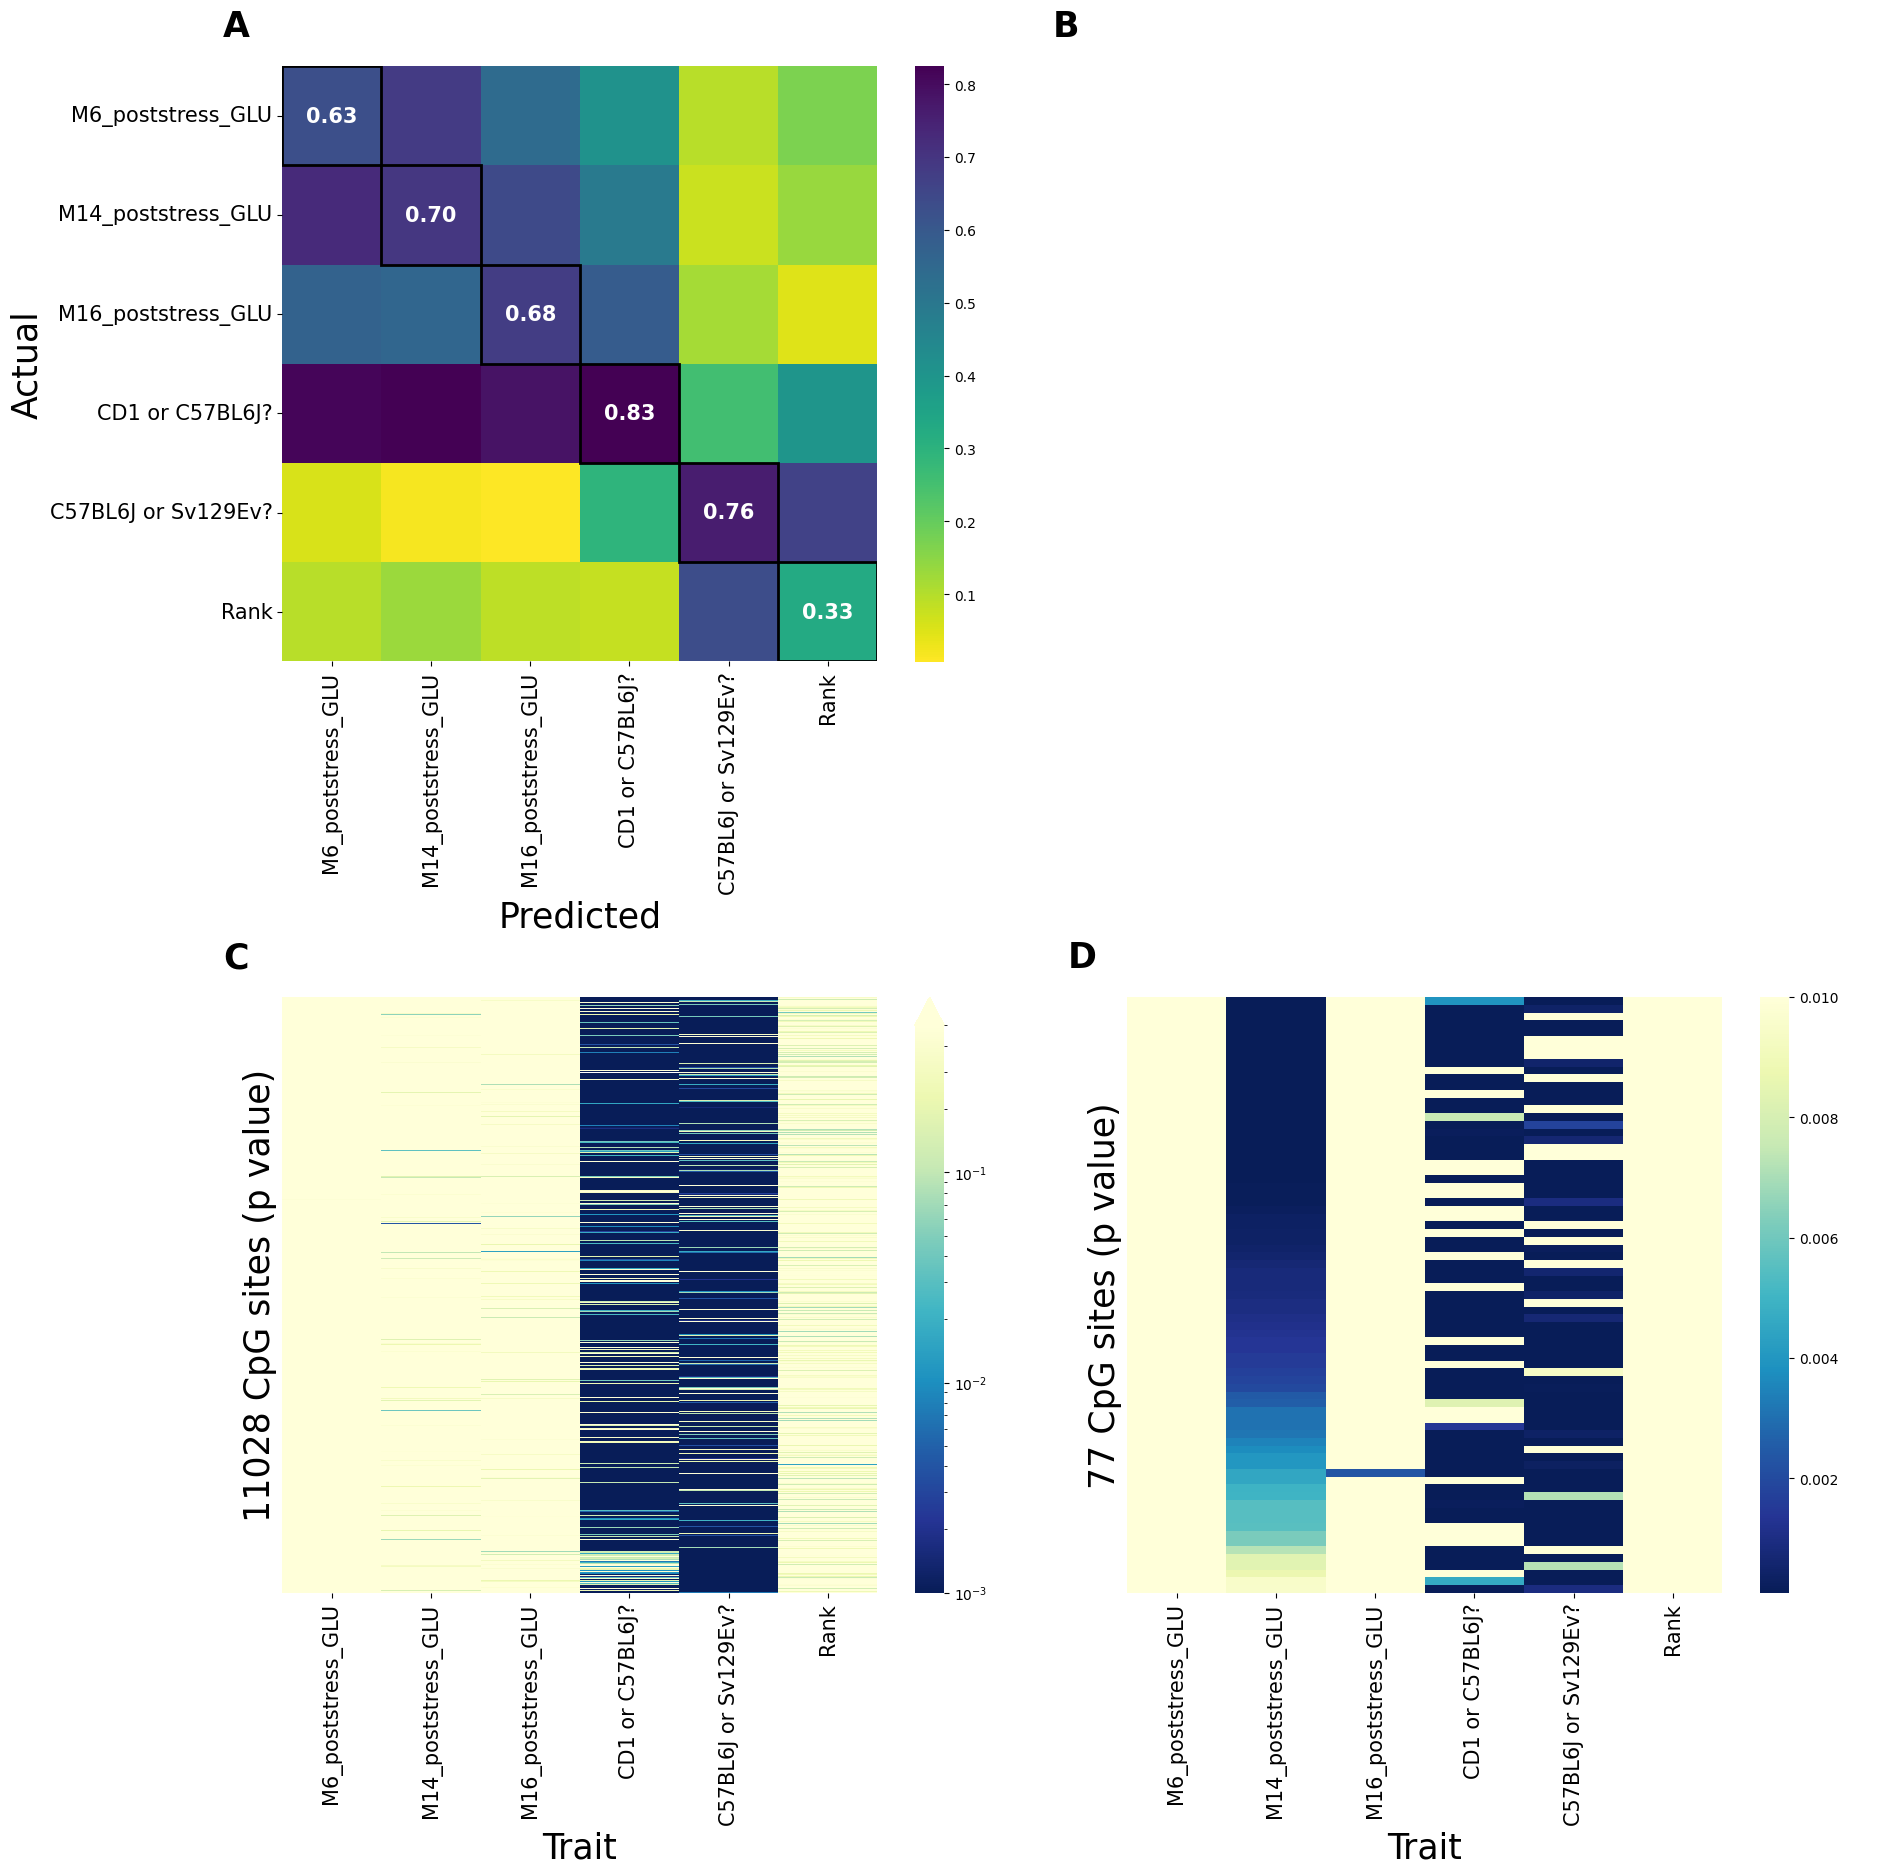

In [111]:
# get the mm10 converted probes
mm39_data = pd.read_excel('mm39_formatted_manifest.xlsx', index_col=0)
probe_df = get_pos(trait_vals, mm39_data);

#####

fig, axs = plt.subplots(2, 2, figsize=(20, 20))  # Create subplots with 2x2 layout

#####

# create dfs for predicted vs. actual results
df_pred = pd.DataFrame(pred) 
df_actual = pd.DataFrame(actual)

# create an empty df for the correlation results
correlation_results = pd.DataFrame(index=df_actual.columns, columns=df_pred.columns)

# get the spearman coefficient for each probe
for pred_key in df_pred.columns:
    for actual_key in df_actual.columns:
        correlation_results.loc[actual_key, pred_key] = df_pred[pred_key].corr(df_actual[actual_key], method='spearman')

# convert the coefficients to absolute values
correlation_matrix = correlation_results.astype(float).abs()

# create a heatmap showing the correlation between traits
sns.heatmap(correlation_matrix, annot=False, cmap='viridis_r', cbar=True, square=True, ax=axs[0, 0])
for i in range(len(correlation_results)):
    axs[0, 0].text(i + 0.5, i + 0.5, f"{correlation_results.iloc[i, i]:.2f}", 
                   ha='center', va='center', color='white', fontsize=15, weight='bold')
    axs[0, 0].add_patch(plt.Rectangle((i, i), 1, 1, edgecolor='black', facecolor='none', lw=2))

axs[0, 0].set_xlabel('Predicted', fontsize=25)
axs[0, 0].set_ylabel('Actual', fontsize=25)

#####

# this is the space for the formulas

# get rid of the box
axs[0, 1].axis('off')

# create a heatmap showing the p values for each site/trait
df_pvals = pd.DataFrame(trait_pvals)
sns.heatmap(df_pvals, norm=LogNorm(vmin=0.001, vmax=0.5), cmap='YlGnBu_r', 
            cbar_kws={'extend': 'max'}, ax=axs[1, 0])

axs[1, 0].set_xlabel('Trait', fontsize=25)
axs[1, 0].set_ylabel(f'{df_pvals.shape[0]} CpG sites (p value)', fontsize=25)
axs[1, 0].set_yticks([])

#####

sig_df = insig_nan(probe_df)
trait = 'M14_poststress_GLU_pval'

# filter significant p-values for the selected trait
temp = sig_df[trait].values
temp = temp[~np.isnan(temp)]
n_probes = len(temp)

# add the probe names to the index
temp_pval_df = pd.DataFrame(trait_pvals)
temp_pval_df.index = trait_vals.index

# make a dataframe for the heatmap
heatmap_df = temp_pval_df.sort_values(by=trait[:-5])
heatmap_df = heatmap_df.iloc[:n_probes]
heatmap_df = heatmap_df.fillna(1)

# make a heatmap showing the p values for specifically M14 blood glucoses
sns.heatmap(heatmap_df, cmap='YlGnBu_r', vmin=0.0001, vmax=0.01, 
            mask=(heatmap_df == 1), ax=axs[1, 1])

axs[1, 1].set_xlabel('Trait', fontsize=25)
axs[1, 1].set_ylabel(f'{n_probes} CpG sites (p value)', fontsize=25)
axs[1, 1].set_yticks([])

#####

# add subplot indicators
for i, ax in enumerate(axs.flat):  # Use axs.flat to iterate over all axes in a flattened array
    ax.text(-0.1, 1.05, chr(65 + i), transform=ax.transAxes, fontsize=25, fontweight='bold')  # 65 is ASCII for 'A'

# adjust the tick mark sizes
for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=15)  
    ax.tick_params(axis='both', which='minor', labelsize=15) 

# adjust layout
plt.tight_layout(pad=5)

Find how many mm39s had no equivalent conversion

In [113]:
non_nan_count = trait_vals['pos_mm10'].isna().sum()
print(f'there are {non_nan_count} sites without mm10 equivalents')

trait_mm10_valid = trait_vals.copy()
trait_mm10_valid = trait_mm10_valid.dropna()
print(trait_mm10_valid.shape)

there are 3 sites without mm10 equivalents
(11025, 18)


Get the number of significant probes for each trait

In [114]:
sig_df = insig_nan(probe_df)
non_nans = sig_df.count()

for column, name in zip(non_nans, sig_df.columns):
    if 'pval' in name:
            # print the number of non-NaN values for all other pval columns
            print(f'{name[:-5]}: {column}')

print('\n')
count_cumulative_probes(sig_df, 'C57BL6J or Sv129Ev?_pval', 'CD1 or C57BL6J?_pval')
count_cumulative_probes(sig_df, 'M16_poststress_GLU_pval', 'M14_poststress_GLU_pval')

M6_poststress_GLU: 0
M14_poststress_GLU: 77
M16_poststress_GLU: 13
CD1 or C57BL6J?: 9387
C57BL6J or Sv129Ev?: 9539
Rank: 0


C57BL6J or Sv129Ev?_pval and CD1 or C57BL6J?_pval: 11023
M16_poststress_GLU_pval and M14_poststress_GLU_pval: 89


Generate a clustermap of significant probes the for selected trait (for the mm39 assembly)


Find the gene associations of probes via GREAT

In [115]:
temp = probe_df.reset_index()
temp = great_analysis(temp, get='genes', df_chr ='chr_mm10', df_start='pos_mm10', df_end='end_mm10', df_index='index')

temp = temp.set_index('index')
trait_vals['associated_genes'] = temp['associated_genes']

trait_vals.to_excel('C:\\Users\\Q004\\Desktop\\pellegrini_lab_research\\model_outputs\\pseudoinverse_probes_filtered.xlsx')
#trait_vals.to_excel('C:\\Users\\Sam Anderson\\Desktop\\pellegrini_lab_research\\model_outputs\\pseudoinverse_probes_filtered.xlsx')
trait_vals

,M6_poststress_GLU_pval,M6_poststress_GLU_coef,M14_poststress_GLU_pval,M14_poststress_GLU_coef,M16_poststress_GLU_pval,M16_poststress_GLU_coef,CD1 or C57BL6J?_pval,CD1 or C57BL6J?_coef,C57BL6J or Sv129Ev?_pval,C57BL6J or Sv129Ev?_coef,Rank_pval,Rank_coef,chr_mm39,pos_mm39,end_mm39,chr_mm10,pos_mm10,end_mm10,associated_genes
cg06259996_TC21,0.928929,-0.003501,0.912400,-0.001720,0.508324,0.004018,1.650489e-08,-0.044189,2.303429e-12,-0.053409,0.991374,-0.000075,chr13,78346406,78346408,chr13,78198287.0,78198289.0,"Nr2f1 (+1,469), Pou5f2 (+173,386)"
cg11548411_BC21,0.976431,0.001308,0.504137,-0.004887,0.192501,0.007552,1.017971e-11,-0.072687,1.061140e-14,-0.077803,0.980108,0.000164,chr19,45290832,45290834,chr19,45302393.0,45302395.0,"Lbx1 (-66,582), Btrc (-61,357)"
cg20012035_TC21,0.971319,-0.005137,0.748280,-0.007050,0.809061,-0.004278,1.042725e-12,0.159658,1.476367e-13,0.142738,0.999158,0.000015,chr12,111505954,111505956,chr12,111539520.0,111539522.0,"Mark3 (-35,006), Eif5 (+1,505)"
cg28108104_TC21,0.888162,0.013848,0.962583,-0.003162,0.850752,0.005051,1.223186e-10,-0.187979,3.239231e-13,-0.196948,0.082068,-0.027040,chr10,3052673,3052675,chr10,3102673.0,3102675.0,"H60c (+165,097)"
cg28108944_BC11,0.996318,0.000343,0.986155,0.000662,0.991432,-0.000150,1.689171e-13,0.112242,6.875975e-07,0.048981,0.840250,0.001754,chr12,20109465,20109467,chr12,20059464.0,20059466.0,"Gm10479 (-356,473)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg48343432_BC11,0.969698,-0.030536,0.859658,0.028164,0.773961,-0.025392,1.743734e-09,0.625325,7.087373e-03,0.190151,0.789910,0.017934,chrY,90751530,90751532,chrY,90740261.0,90740263.0,"Gm21996 (-994,730), Erdr1 (-44,476)"
cg48343860_TC21,0.971216,-0.015349,0.731767,0.021715,0.719773,-0.017124,8.470231e-16,0.611274,1.444248e-09,0.297000,0.908738,0.004666,chrY,90771588,90771590,chrY,90760319.0,90760321.0,"Erdr1 (-24,418)"
cg48344016_TC11,0.974214,-0.009442,0.958422,0.004524,0.956304,0.002051,1.476085e-12,0.296254,7.917122e-01,0.006530,0.537936,-0.012545,chrY,90813306,90813308,chrY,90802037.0,90802039.0,"Erdr1 (+17,300)"
cg48344082_BC11,0.999776,0.000211,0.947403,0.009648,0.927244,-0.005977,4.083174e-10,0.407126,1.467479e-04,0.171534,0.607566,0.018867,chrY,90816641,90816643,chrY,90805372.0,90805374.0,"Erdr1 (+20,635)"


Get rid of the insignificant p values so they are not used in analysis

In [116]:
# remove insignificant p values
trait_vals_no_insig = trait_vals.copy()
numeric_cols = trait_vals_no_insig.select_dtypes(include=[np.number]).columns
trait_vals_no_insig[numeric_cols] = trait_vals_no_insig[numeric_cols].applymap(lambda x: np.nan if x > 0.01 else x) # or map depending on pd version you are using

# restore position info
trait_vals_no_insig['pos_mm10'] = trait_vals['pos_mm10']
trait_vals_no_insig['end_mm10'] = trait_vals['end_mm10']
trait_vals_no_insig['pos_mm39'] = trait_vals['pos_mm39']
trait_vals_no_insig['end_mm39'] = trait_vals['end_mm39']

trait_vals_no_insig

C:\Users\Q004\AppData\Local\Temp\ipykernel_21608\4178188531.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  trait_vals_no_insig[numeric_cols] = trait_vals_no_insig[numeric_cols].applymap(lambda x: np.nan if x > 0.01 else x) # or map depending on pd version you are using


,M6_poststress_GLU_pval,M6_poststress_GLU_coef,M14_poststress_GLU_pval,M14_poststress_GLU_coef,M16_poststress_GLU_pval,M16_poststress_GLU_coef,CD1 or C57BL6J?_pval,CD1 or C57BL6J?_coef,C57BL6J or Sv129Ev?_pval,C57BL6J or Sv129Ev?_coef,Rank_pval,Rank_coef,chr_mm39,pos_mm39,end_mm39,chr_mm10,pos_mm10,end_mm10,associated_genes
cg06259996_TC21,NaN,-0.003501,NaN,-0.001720,NaN,0.004018,1.650489e-08,-0.044189,2.303429e-12,-0.053409,NaN,-0.000075,chr13,78346406,78346408,chr13,78198287.0,78198289.0,"Nr2f1 (+1,469), Pou5f2 (+173,386)"
cg11548411_BC21,NaN,0.001308,NaN,-0.004887,NaN,0.007552,1.017971e-11,-0.072687,1.061140e-14,-0.077803,NaN,0.000164,chr19,45290832,45290834,chr19,45302393.0,45302395.0,"Lbx1 (-66,582), Btrc (-61,357)"
cg20012035_TC21,NaN,-0.005137,NaN,-0.007050,NaN,-0.004278,1.042725e-12,NaN,1.476367e-13,NaN,NaN,0.000015,chr12,111505954,111505956,chr12,111539520.0,111539522.0,"Mark3 (-35,006), Eif5 (+1,505)"
cg28108104_TC21,NaN,NaN,NaN,-0.003162,NaN,0.005051,1.223186e-10,-0.187979,3.239231e-13,-0.196948,NaN,-0.027040,chr10,3052673,3052675,chr10,3102673.0,3102675.0,"H60c (+165,097)"
cg28108944_BC11,NaN,0.000343,NaN,0.000662,NaN,-0.000150,1.689171e-13,NaN,6.875975e-07,NaN,NaN,0.001754,chr12,20109465,20109467,chr12,20059464.0,20059466.0,"Gm10479 (-356,473)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg48343432_BC11,NaN,-0.030536,NaN,NaN,NaN,-0.025392,1.743734e-09,NaN,7.087373e-03,NaN,NaN,NaN,chrY,90751530,90751532,chrY,90740261.0,90740263.0,"Gm21996 (-994,730), Erdr1 (-44,476)"
cg48343860_TC21,NaN,-0.015349,NaN,NaN,NaN,-0.017124,8.470231e-16,NaN,1.444248e-09,NaN,NaN,0.004666,chrY,90771588,90771590,chrY,90760319.0,90760321.0,"Erdr1 (-24,418)"
cg48344016_TC11,NaN,-0.009442,NaN,0.004524,NaN,0.002051,1.476085e-12,NaN,NaN,0.006530,NaN,-0.012545,chrY,90813306,90813308,chrY,90802037.0,90802039.0,"Erdr1 (+17,300)"
cg48344082_BC11,NaN,0.000211,NaN,0.009648,NaN,-0.005977,4.083174e-10,NaN,1.467479e-04,NaN,NaN,NaN,chrY,90816641,90816643,chrY,90805372.0,90805374.0,"Erdr1 (+20,635)"


Combine the strain-associated traits into a single column for analysis, and do the same for the blood glucose associated traits

In [117]:
# strain
cistrome_formatted = trait_vals_no_insig.copy()

cistrome_formatted['Strain_pval'] = cistrome_formatted.apply(lambda row: np.nanmean([row['C57BL6J or Sv129Ev?_pval'], row['CD1 or C57BL6J?_pval']]) 
                        if pd.notna(row['C57BL6J or Sv129Ev?_pval']) or pd.notna(row['CD1 or C57BL6J?_pval']) 
                        else np.nan, axis=1)
cistrome_formatted = cistrome_formatted.drop(columns=['C57BL6J or Sv129Ev?_pval', 'CD1 or C57BL6J?_pval']) # dont need to bother with coef

# blood glucose
cistrome_formatted['Blood Glucose_pval'] = cistrome_formatted.apply(lambda row: np.nanmean([row['M14_poststress_GLU_pval'], row['M16_poststress_GLU_pval']]) 
                        if pd.notna(row['M14_poststress_GLU_pval']) or pd.notna(row['M16_poststress_GLU_pval']) 
                        else np.nan, axis=1)
cistrome_formatted = cistrome_formatted.drop(columns=['M14_poststress_GLU_pval', 'M16_poststress_GLU_pval']) # dont need to bother with coef

# drop rank because it doesn't produce any factors (only 2 probes anyways)
cistrome_formatted = cistrome_formatted.drop(columns=['Rank_pval']) # dont need to bother with coef
cistrome_formatted

,M6_poststress_GLU_pval,M6_poststress_GLU_coef,M14_poststress_GLU_coef,M16_poststress_GLU_coef,CD1 or C57BL6J?_coef,C57BL6J or Sv129Ev?_coef,Rank_coef,chr_mm39,pos_mm39,end_mm39,chr_mm10,pos_mm10,end_mm10,associated_genes,Strain_pval,Blood Glucose_pval
cg06259996_TC21,NaN,-0.003501,-0.001720,0.004018,-0.044189,-0.053409,-0.000075,chr13,78346406,78346408,chr13,78198287.0,78198289.0,"Nr2f1 (+1,469), Pou5f2 (+173,386)",8.253598e-09,NaN
cg11548411_BC21,NaN,0.001308,-0.004887,0.007552,-0.072687,-0.077803,0.000164,chr19,45290832,45290834,chr19,45302393.0,45302395.0,"Lbx1 (-66,582), Btrc (-61,357)",5.095160e-12,NaN
cg20012035_TC21,NaN,-0.005137,-0.007050,-0.004278,NaN,NaN,0.000015,chr12,111505954,111505956,chr12,111539520.0,111539522.0,"Mark3 (-35,006), Eif5 (+1,505)",5.951806e-13,NaN
cg28108104_TC21,NaN,NaN,-0.003162,0.005051,-0.187979,-0.196948,-0.027040,chr10,3052673,3052675,chr10,3102673.0,3102675.0,"H60c (+165,097)",6.132125e-11,NaN
cg28108944_BC11,NaN,0.000343,0.000662,-0.000150,NaN,NaN,0.001754,chr12,20109465,20109467,chr12,20059464.0,20059466.0,"Gm10479 (-356,473)",3.437988e-07,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg48343432_BC11,NaN,-0.030536,NaN,-0.025392,NaN,NaN,NaN,chrY,90751530,90751532,chrY,90740261.0,90740263.0,"Gm21996 (-994,730), Erdr1 (-44,476)",3.543687e-03,NaN
cg48343860_TC21,NaN,-0.015349,NaN,-0.017124,NaN,NaN,0.004666,chrY,90771588,90771590,chrY,90760319.0,90760321.0,"Erdr1 (-24,418)",7.221244e-10,NaN
cg48344016_TC11,NaN,-0.009442,0.004524,0.002051,NaN,0.006530,-0.012545,chrY,90813306,90813308,chrY,90802037.0,90802039.0,"Erdr1 (+17,300)",1.476085e-12,NaN
cg48344082_BC11,NaN,0.000211,0.009648,-0.005977,NaN,NaN,NaN,chrY,90816641,90816643,chrY,90805372.0,90805374.0,"Erdr1 (+20,635)",7.337416e-05,NaN


Get the Cistrome plots using the significant probes

No valid probes, skipping trait M6_poststress_GLU_pval


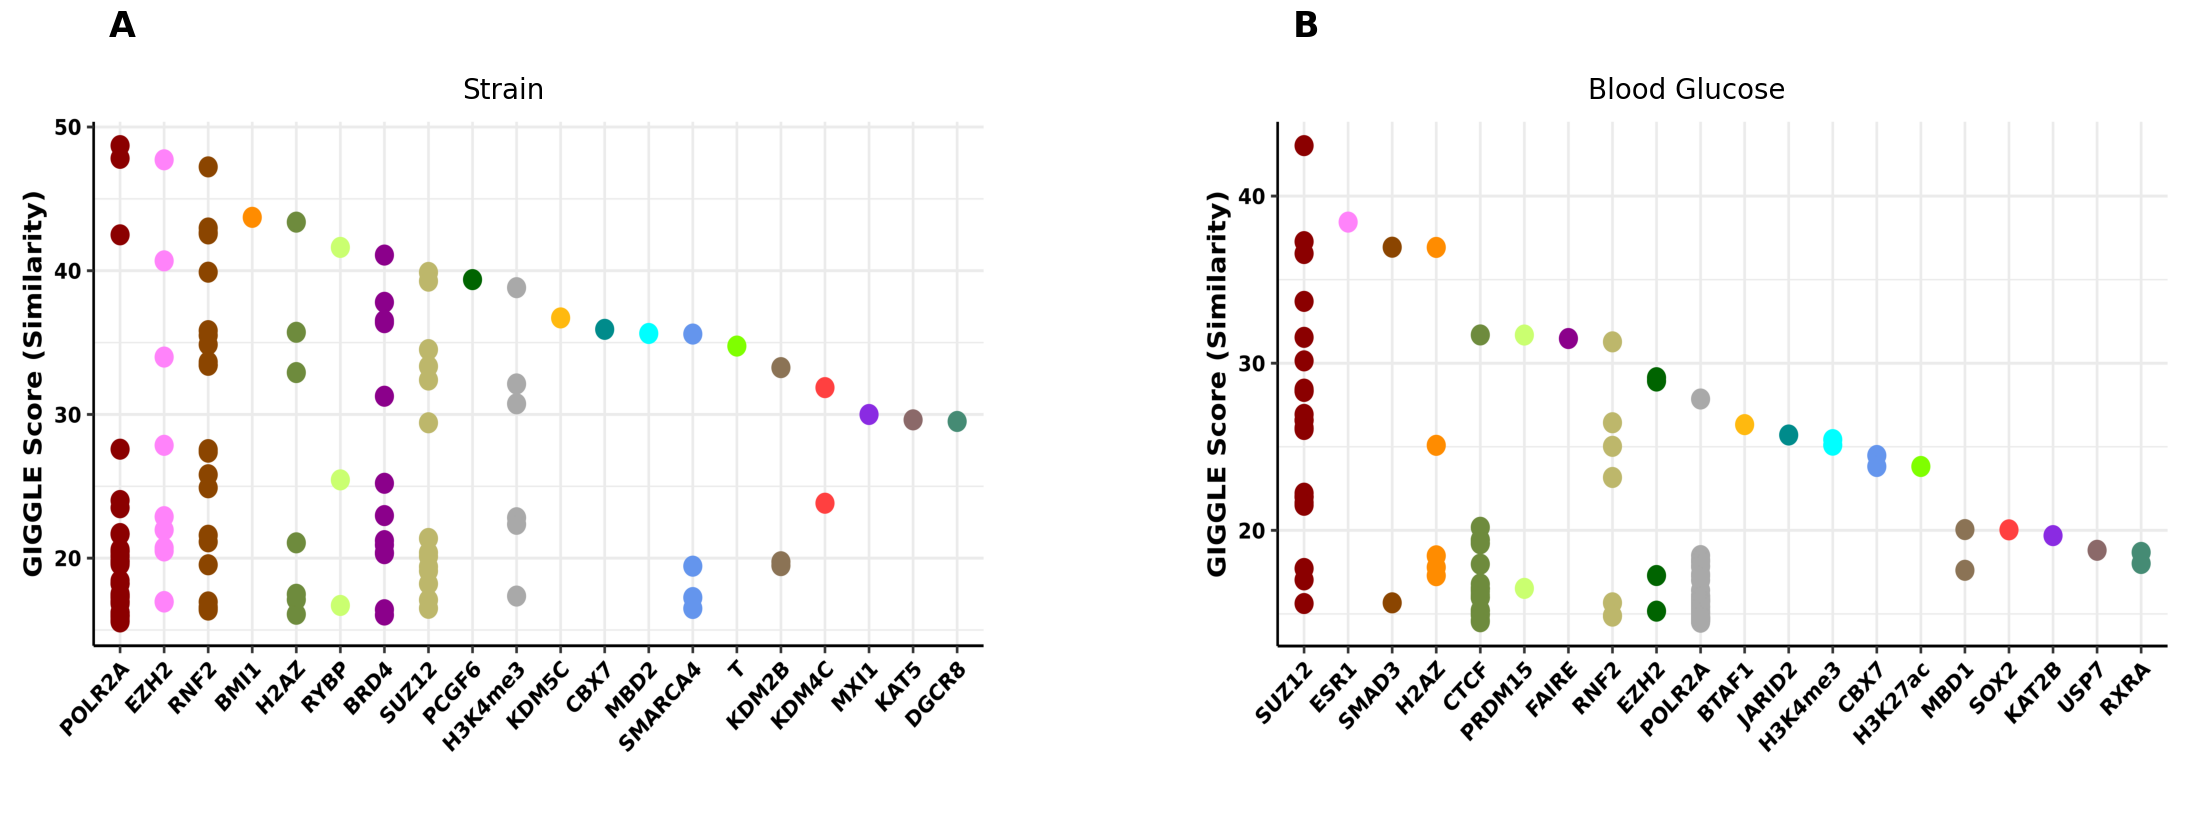

In [118]:
%matplotlib inline

# this is trial and error, unfortunately
'''
2000 for 2
3500 for 3/4
5000 for 5/6
'''
fig_w = 2800
fig_h = 2000

# generate cistrome plots by trait
get_cistrome(cistrome_formatted, fig_w, fig_h)